In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

In [2]:
n_timesteps_in = 60 
n_timesteps_out = 30
n_features_in = 1
n_features_out = 1

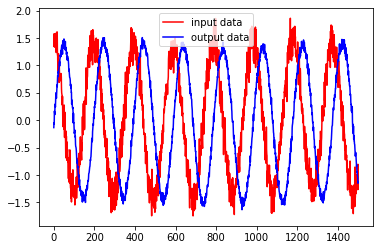

In [7]:
time_series_length = 1500
t = np.linspace(0, 8, time_series_length)
ts_input = np.cos(t) / 5 + 4 * np.cos(t*6) + 0.5 * np.random.standard_normal(size=time_series_length)
ts_output = np.sin(t) / 3 + 8 * np.sin(t*6) + 0.3 * np.random.standard_normal(size=time_series_length)

ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [8]:
train_size = int(len(ts_input) * 0.85)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]


In [9]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)

    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)
        

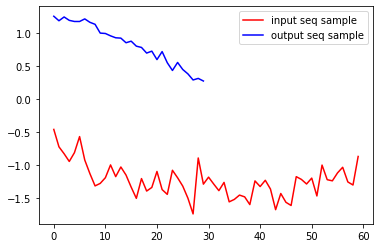

In [10]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()
plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

In [11]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))
n_units = 256
encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        264192      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [12]:
model.compile(optimizer='adam', loss='mse')
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.25, callbacks = my_callbacks, verbose=2)

Epoch 1/100
6/6 - 13s - loss: 0.6985 - val_loss: 0.2079 - 13s/epoch - 2s/step
Epoch 2/100
6/6 - 5s - loss: 0.2097 - val_loss: 0.1545 - 5s/epoch - 846ms/step
Epoch 3/100
6/6 - 5s - loss: 0.1486 - val_loss: 0.1104 - 5s/epoch - 802ms/step
Epoch 4/100
6/6 - 5s - loss: 0.0979 - val_loss: 0.0886 - 5s/epoch - 845ms/step
Epoch 5/100
6/6 - 5s - loss: 0.0788 - val_loss: 0.0719 - 5s/epoch - 767ms/step
Epoch 6/100
6/6 - 5s - loss: 0.0617 - val_loss: 0.0521 - 5s/epoch - 780ms/step
Epoch 7/100
6/6 - 5s - loss: 0.0521 - val_loss: 0.0408 - 5s/epoch - 758ms/step
Epoch 8/100
6/6 - 5s - loss: 0.0436 - val_loss: 0.0378 - 5s/epoch - 858ms/step
Epoch 9/100
6/6 - 4s - loss: 0.0328 - val_loss: 0.0214 - 4s/epoch - 748ms/step
Epoch 10/100
6/6 - 4s - loss: 0.0248 - val_loss: 0.0304 - 4s/epoch - 748ms/step
Epoch 11/100
6/6 - 5s - loss: 0.0212 - val_loss: 0.0157 - 5s/epoch - 781ms/step
Epoch 12/100
6/6 - 5s - loss: 0.0161 - val_loss: 0.0130 - 5s/epoch - 827ms/step
Epoch 13/100
6/6 - 5s - loss: 0.0136 - val_loss: 0

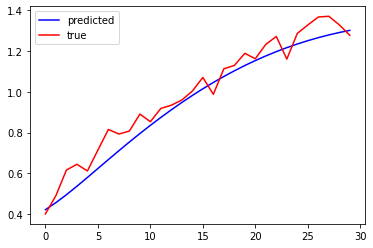

In [13]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()

In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [75]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('image shape', x_train[0].shape)

60000 train samples
10000 test samples
image shape (28, 28)


In [76]:
original_dim = 28 * 28 

x_train = x_train.reshape(60000, original_dim)
x_test = x_test.reshape(10000, original_dim)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [77]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [78]:
def encoder():
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return

In [79]:
def plot_res(encoder, decoder, x_test, y_test, batch_size=128):

    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [80]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [81]:
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense_16[0][0]']               
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense_16[0][0]']               
                                                                                            

In [82]:
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_17 (Dense)            (None, 512)               1536      
                                                                 
 dense_18 (Dense)            (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [83]:
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs)
reconstruction_loss = keras.losses.binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          403972      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          403728      ['encoder[0][2]']                
                                                                                            

In [85]:
vae.fit(x_train,  epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))


Epoch 1/50
469/469 [==============================] - 21s 41ms/step - loss: 305.7229 - val_loss: 282.0774
Epoch 2/50
469/469 [==============================] - 20s 43ms/step - loss: 278.1438 - val_loss: 276.5984
Epoch 3/50
469/469 [==============================] - 21s 45ms/step - loss: 273.8234 - val_loss: 273.7737
Epoch 4/50
469/469 [==============================] - 22s 46ms/step - loss: 271.4229 - val_loss: 271.6000
Epoch 5/50
469/469 [==============================] - 19s 41ms/step - loss: 269.8969 - val_loss: 270.1338
Epoch 6/50
469/469 [==============================] - 21s 44ms/step - loss: 268.6673 - val_loss: 269.1384
Epoch 7/50
469/469 [==============================] - 21s 44ms/step - loss: 267.6070 - val_loss: 268.1013
Epoch 8/50
469/469 [==============================] - 19s 40ms/step - loss: 266.7401 - val_loss: 267.6479
Epoch 9/50
469/469 [==============================] - 21s 44ms/step - loss: 266.0105 - val_loss: 266.8285
Epoch 10/50
469/469 [=========================

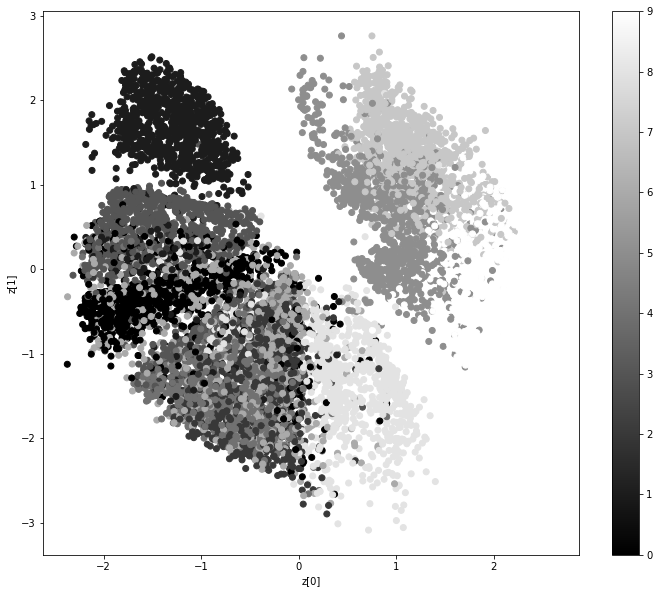

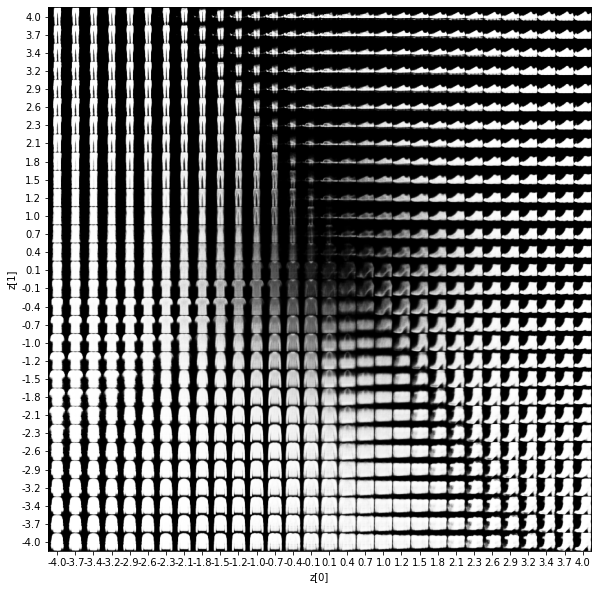

In [86]:
plot_res(encoder, decoder, x_test, y_test, batch_size=batch_size)